Epoch 1/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.0053
Epoch 2/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 3/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 4/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 6/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 7/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 8/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 11/

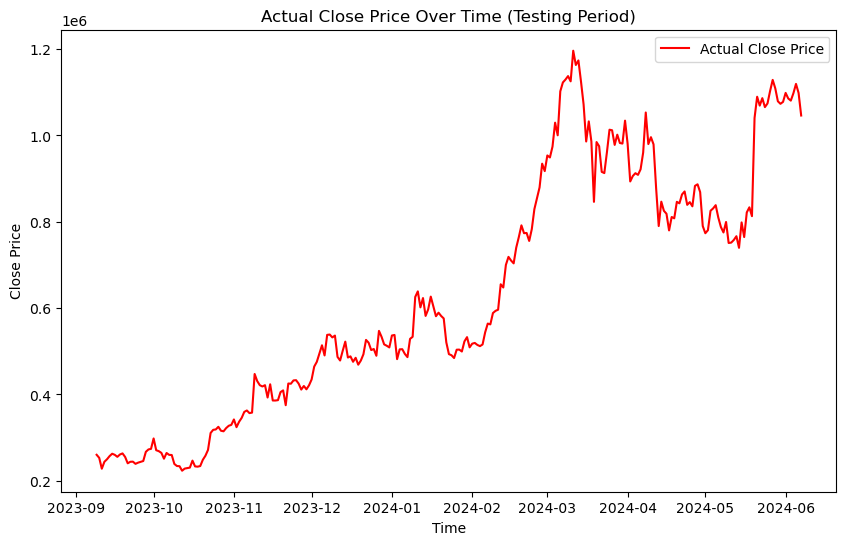

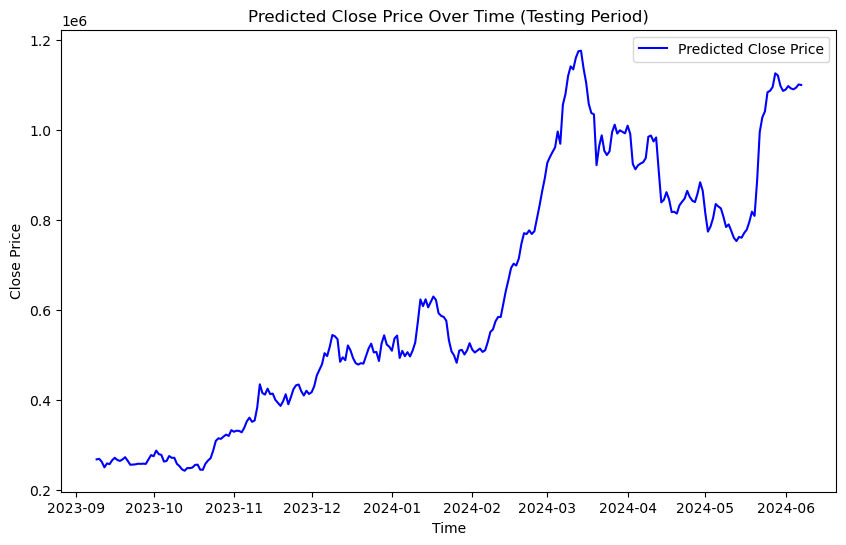

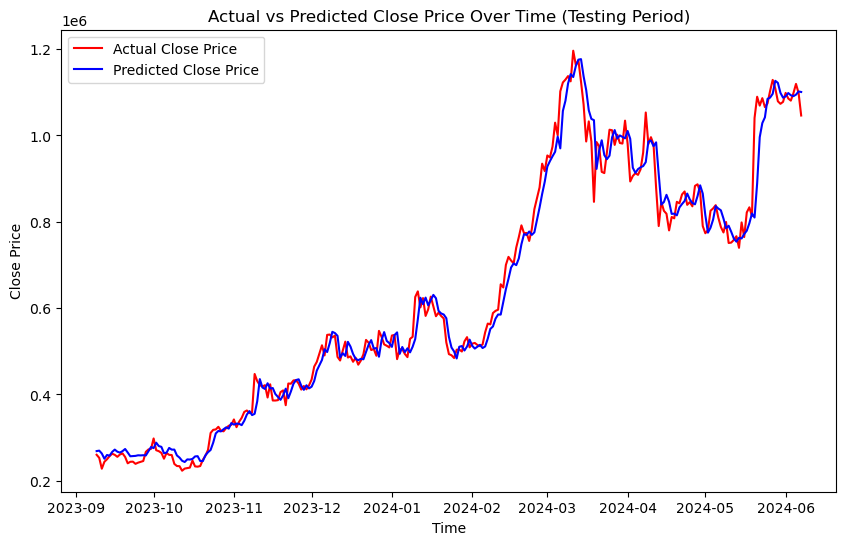

1/1 [==============================] - 0s 8ms/step
Predicted Close Price for the Next Day: 1059500.534413386


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Step 1: Load Data from CSV (daily data)
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/CNN/ETH-USD_1d_2021_to_2024_cleaned.csv'
data = pd.read_csv(file_path)

# Convert the time column to datetime (using the correct format)
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d')
data = data.sort_values('time')

# Step 2: Set the time column as the index and specify the frequency
data.set_index('time', inplace=True)
data = data.asfreq('D')  # Ensure the frequency is daily

# Focus on all features including 'open', 'high', 'low', 'close', and 'volume'
features = ['open', 'high', 'low', 'close', 'volume']
data = data[features]

# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Step 4: Create sequences for CNN input
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 3])  # Target is 'close' price
    return np.array(sequences), np.array(targets)

sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Reshape X to fit CNN input requirements: (samples, sequence_length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 5: Train-Test Split
train_size = int(X.shape[0] * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Step 7: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Step 8: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Inverse transform to get the actual prices
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), data_scaled.shape[1]-1)), y_pred), axis=1))[:, -1]

# Step 9: Evaluate the Model
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Step 10: Visualization with the testing time frame

# Correct the index for plotting
test_index = data.index[sequence_length + train_size:]

# 1. Actual Data Plot over time (during testing time frame)
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual Close Price Over Time (Testing Period)')
plt.legend()
plt.show()

# 2. Predicted Data Plot over time (during testing time frame)
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Predicted Close Price Over Time (Testing Period)')
plt.legend()
plt.show()

# 3. Combined Actual vs Predicted Plot (during testing time frame)
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price Over Time (Testing Period)')
plt.legend()
plt.show()

# Step 11: Save the Model in .keras Format
model_filename = 'cnn_model_eth_1d.keras'
model.save(model_filename)
scaler_filename = 'scaler_eth_1d.pkl'
joblib.dump(scaler, scaler_filename)

# Step 12: Real-Time Prediction using the last available data
# Use the last available data to predict the next day
last_sequence = data_scaled[-sequence_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)
next_day_prediction_scaled = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, data_scaled.shape[1]-1)), next_day_prediction_scaled), axis=1))[:, -1]

print(f'Predicted Close Price for the Next Day: {next_day_prediction[0]}')


Epoch 1/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0184
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/

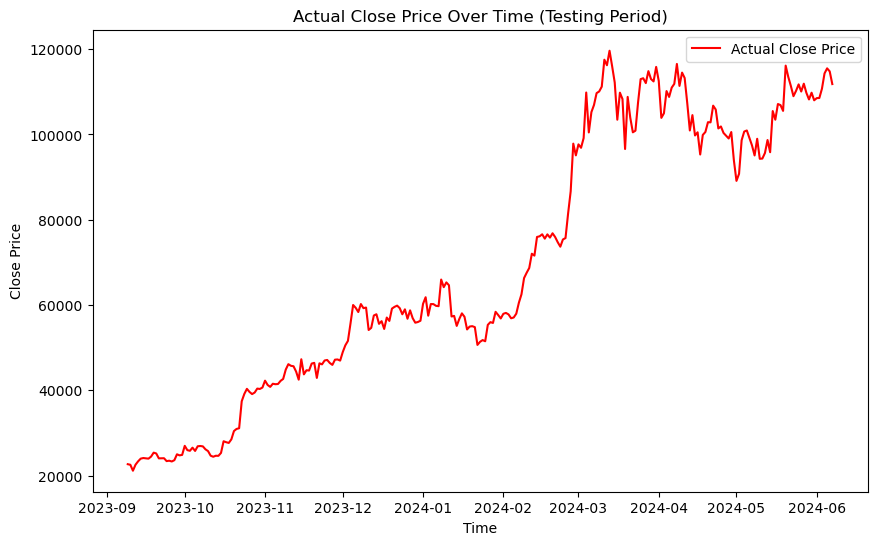

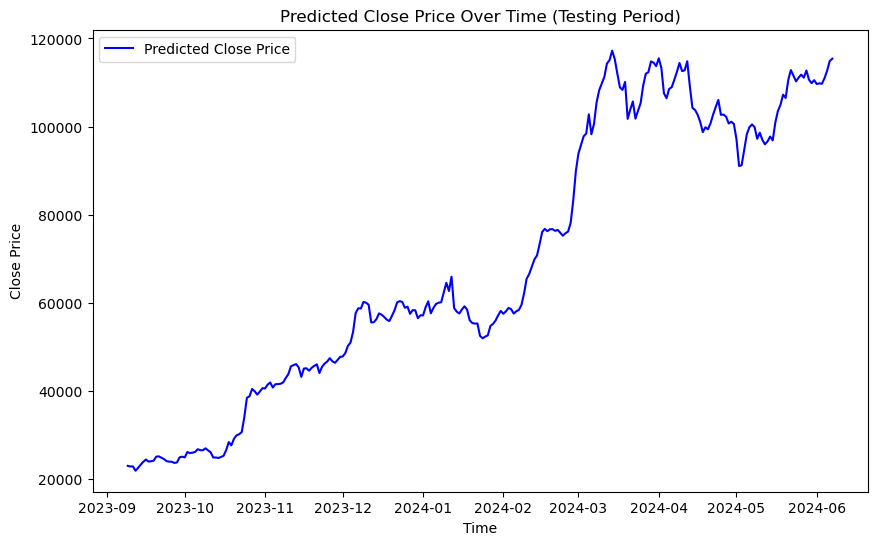

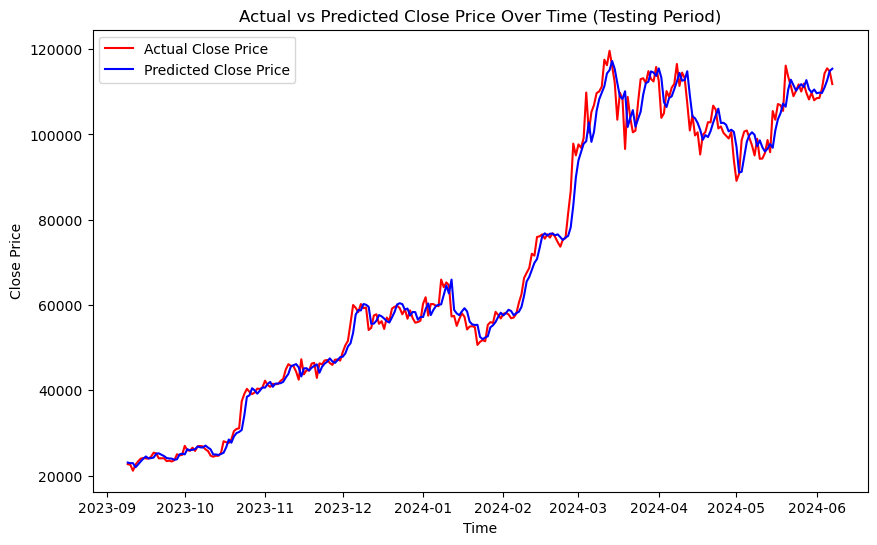

1/1 [==============================] - 0s 7ms/step
Predicted Close Price for the Next Day: 113764.1407538095


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Step 1: Load Data from CSV (daily data)
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/CNN/BTC-USD_1d_2021_to_2024_cleaned.csv'
data = pd.read_csv(file_path)

# Convert the time column to datetime (using the correct format)
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d')
data = data.sort_values('time')

# Step 2: Set the time column as the index and specify the frequency
data.set_index('time', inplace=True)
data = data.asfreq('D')  # Ensure the frequency is daily

# Focus on all features including 'open', 'high', 'low', 'close', and 'volume'
features = ['open', 'high', 'low', 'close', 'volume']
data = data[features]

# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Step 4: Create sequences for CNN input
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 3])  # Target is 'close' price
    return np.array(sequences), np.array(targets)

sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Reshape X to fit CNN input requirements: (samples, sequence_length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 5: Train-Test Split
train_size = int(X.shape[0] * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Step 7: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Step 8: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Inverse transform to get the actual prices
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), data_scaled.shape[1]-1)), y_pred), axis=1))[:, -1]

# Step 9: Evaluate the Model
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Step 10: Visualization with the testing time frame

# Correct the index for plotting
test_index = data.index[sequence_length + train_size:]

# 1. Actual Data Plot over time (during testing time frame)
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual Close Price Over Time (Testing Period)')
plt.legend()
plt.show()

# 2. Predicted Data Plot over time (during testing time frame)
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Predicted Close Price Over Time (Testing Period)')
plt.legend()
plt.show()

# 3. Combined Actual vs Predicted Plot (during testing time frame)
plt.figure(figsize=(10, 6))
plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price Over Time (Testing Period)')
plt.legend()
plt.show()

# Step 11: Save the Model in .keras Format
model_filename = 'cnn_model_btc_1d.keras'
model.save(model_filename)
scaler_filename = 'scaler_btc_1d.pkl'
joblib.dump(scaler, scaler_filename)

# Step 12: Real-Time Prediction using the last available data
# Use the last available data to predict the next day
last_sequence = data_scaled[-sequence_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)
next_day_prediction_scaled = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, data_scaled.shape[1]-1)), next_day_prediction_scaled), axis=1))[:, -1]

print(f'Predicted Close Price for the Next Day: {next_day_prediction[0]}')


In [ ]:
1hbtc

Checking for NaN values in the original data...
open      4
high      4
low       4
close     4
volume    4
dtype: int64
Checking for NaN values after filling...
open      0
high      0
low       0
close     0
volume    0
dtype: int64
Checking for NaN or Infinite values in the scaled data...
False
False
Epoch 1/100
617/617 [==============================] - 1s 738us/step - loss: 0.0011 - val_loss: 2.3538e-04
Epoch 2/100
617/617 [==============================] - 0s 722us/step - loss: 2.5070e-04 - val_loss: 6.2062e-04
Epoch 3/100
617/617 [==============================] - 0s 759us/step - loss: 2.0052e-04 - val_loss: 4.0283e-04
Epoch 4/100
617/617 [==============================] - 0s 660us/step - loss: 1.7485e-04 - val_loss: 6.8424e-05
Epoch 5/100
617/617 [==============================] - 0s 685us/step - loss: 1.6411e-04 - val_loss: 0.0018
Epoch 6/100
617/617 [==============================] - 0s 717us/step - loss: 1.4477e-04 - val_loss: 3.0722e-04
Epoch 7/100
617/617 [================

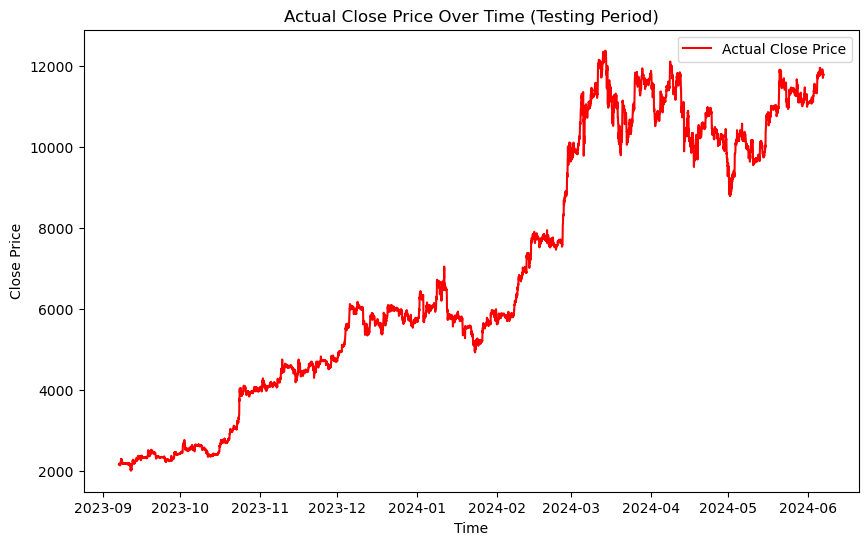

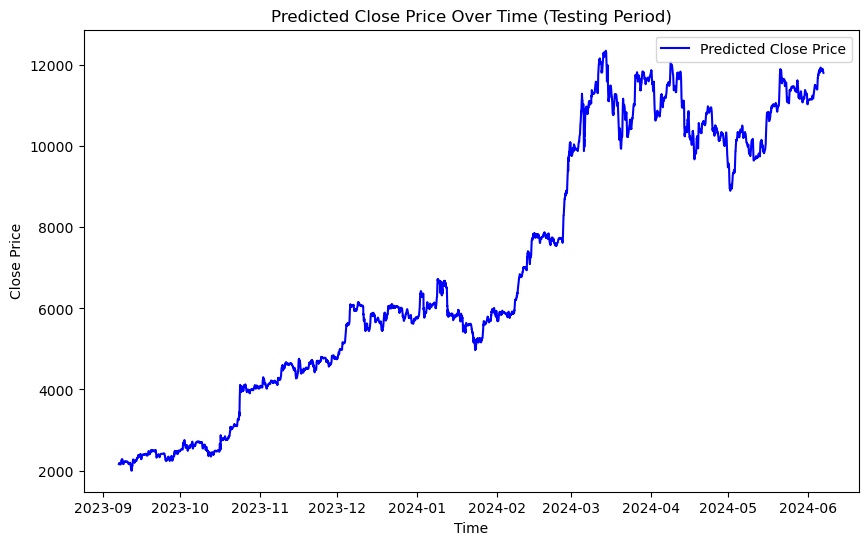

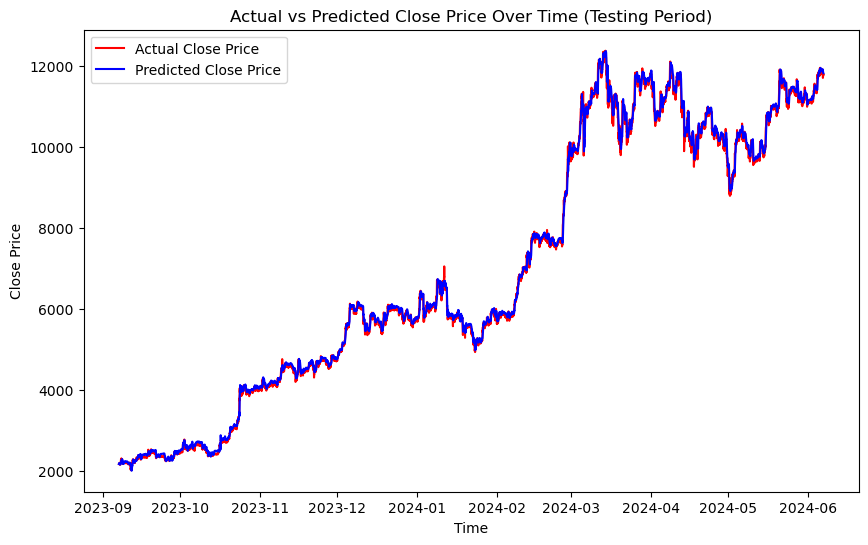

1/1 [==============================] - 0s 9ms/step
Predicted Close Price for the Next Hour: 11801.642762703168


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Step 1: Load Data from CSV (hourly data)
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/CNN/BTCUSD_1h_2021_to_2024_cleaned.csv'  # Replace with the correct path
data = pd.read_csv(file_path)

# Convert the time column to datetime (using the correct format)
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data = data.sort_values('time')

# Step 2: Set the time column as the index and specify the frequency
data.set_index('time', inplace=True)
data = data.asfreq('H')  # Ensure the frequency is hourly

# Check for NaN values before scaling
print("Checking for NaN values in the original data...")
print(data.isna().sum())

# If NaN values exist, we can choose to fill or drop them. Here we fill them with the mean value of the respective column
data = data.fillna(method='ffill').fillna(method='bfill')

# Check again after filling
print("Checking for NaN values after filling...")
print(data.isna().sum())

# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Check for NaN or Infinite values after scaling
print("Checking for NaN or Infinite values in the scaled data...")
print(np.any(np.isnan(data_scaled)))
print(np.any(np.isinf(data_scaled)))

# Step 4: Create sequences for CNN input
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 3])  # Target is 'close' price
    return np.array(sequences), np.array(targets)

sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Reshape X to fit CNN input requirements: (samples, sequence_length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 5: Train-Test Split
train_size = int(X.shape[0] * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Using legacy optimizer for better performance on M1/M2 Macs
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')

# Step 7: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Step 8: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Inverse transform to get the actual prices
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), data_scaled.shape[1]-1)), y_pred), axis=1))[:, -1]

# Step 9: Check and handle NaN values before evaluation
print("Checking for NaN values in y_test_inv and y_pred_inv...")
print(f"NaN in y_test_inv: {np.isnan(y_test_inv).sum()}")
print(f"NaN in y_pred_inv: {np.isnan(y_pred_inv).sum()}")

# Remove NaN values
valid_indices = ~np.isnan(y_test_inv) & ~np.isnan(y_pred_inv)
y_test_inv = y_test_inv[valid_indices]
y_pred_inv = y_pred_inv[valid_indices]

# Ensure arrays are not empty
if len(y_test_inv) == 0 or len(y_pred_inv) == 0:
    print("No valid data to evaluate after removing NaN values.")
else:
    # Evaluate the Model
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')

    # Step 10: Visualization with the testing time frame

    # Correct the index for plotting
    test_index = data.index[sequence_length + train_size:sequence_length + train_size + len(y_test_inv)]

    # 1. Actual Data Plot over time (during testing time frame)
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 2. Predicted Data Plot over time (during testing time frame)
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 3. Combined Actual vs Predicted Plot (during testing time frame)
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
    plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # Step 11: Save the Model in .keras Format
    model_filename = 'cnn_model_btc_1h.keras'
    model.save(model_filename)
    scaler_filename = 'scaler_btc_1h.pkl'
    joblib.dump(scaler, scaler_filename)

    # Step 12: Real-Time Prediction using the last available data
    # Use the last available data to predict the next hour
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    next_hour_prediction_scaled = model.predict(last_sequence)
    next_hour_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, data_scaled.shape[1]-1)), next_hour_prediction_scaled), axis=1))[:, -1]

    print(f'Predicted Close Price for the Next Hour: {next_hour_prediction[0]}')


In [ ]:
1h eth

Checking for NaN values in the original data...
open      3
high      3
low       3
close     3
volume    3
dtype: int64
Checking for NaN values after filling...
open      0
high      0
low       0
close     0
volume    0
dtype: int64
Checking for NaN or Infinite values in the scaled data...
False
False
Epoch 1/100
617/617 [==============================] - 1s 767us/step - loss: 0.0027 - val_loss: 3.2601e-04
Epoch 2/100
617/617 [==============================] - 1s 933us/step - loss: 3.7788e-04 - val_loss: 3.4322e-04
Epoch 3/100
617/617 [==============================] - 0s 719us/step - loss: 3.2341e-04 - val_loss: 6.9402e-05
Epoch 4/100
617/617 [==============================] - 0s 688us/step - loss: 2.8007e-04 - val_loss: 7.5525e-05
Epoch 5/100
617/617 [==============================] - 0s 726us/step - loss: 2.4949e-04 - val_loss: 8.7869e-04
Epoch 6/100
617/617 [==============================] - 0s 698us/step - loss: 2.4342e-04 - val_loss: 8.7431e-05
Epoch 7/100
617/617 [============

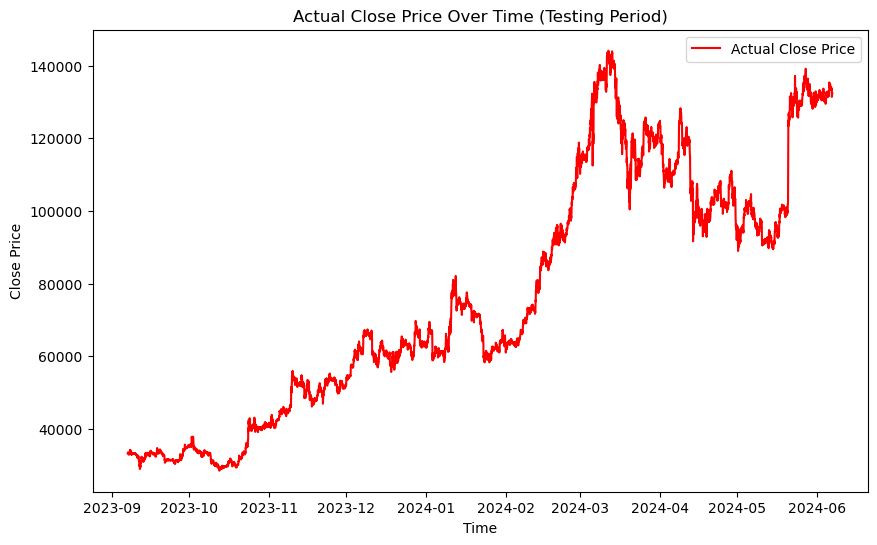

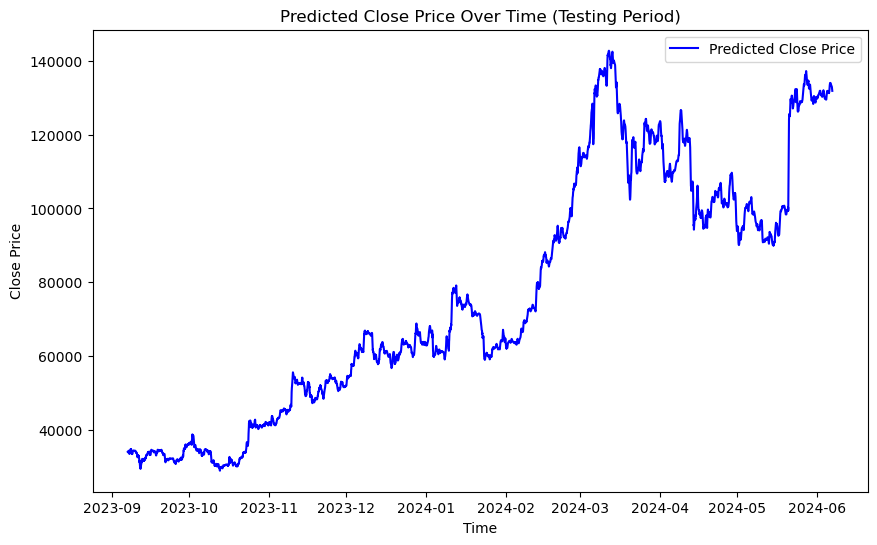

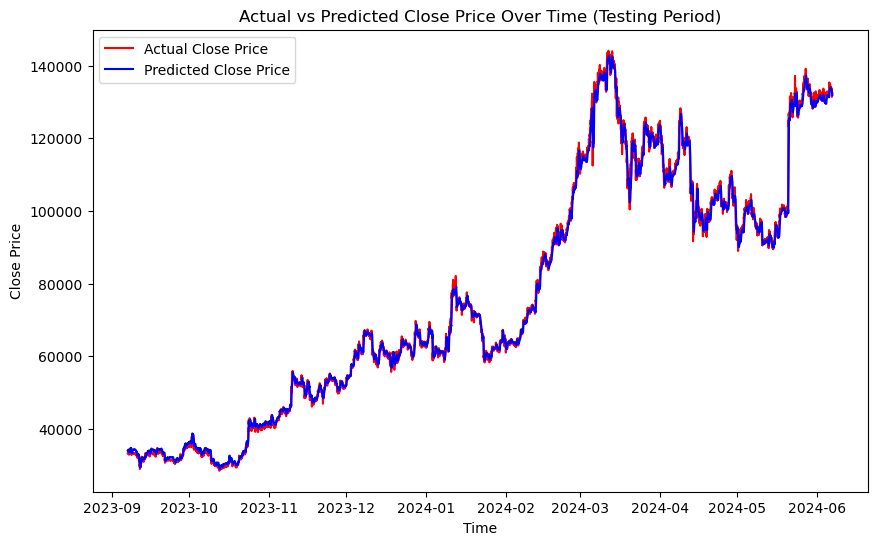

1/1 [==============================] - 0s 8ms/step
Predicted Close Price for the Next Hour: 131714.5773202264


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Step 1: Load Data from CSV (hourly data)
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/CNN/ETHUSD_1h_2021_to_2024_cleaned.csv'  # Replace with the correct path
data = pd.read_csv(file_path)

# Convert the time column to datetime using the correct format
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y %H:%M')
data = data.sort_values('time')

# Step 2: Set the time column as the index and specify the frequency
data.set_index('time', inplace=True)
data = data.asfreq('H')  # Ensure the frequency is hourly

# Check for NaN values before scaling
print("Checking for NaN values in the original data...")
print(data.isna().sum())

# If NaN values exist, we can choose to fill or drop them. Here we fill them with the mean value of the respective column
data = data.fillna(method='ffill').fillna(method='bfill')

# Check again after filling
print("Checking for NaN values after filling...")
print(data.isna().sum())

# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Check for NaN or Infinite values after scaling
print("Checking for NaN or Infinite values in the scaled data...")
print(np.any(np.isnan(data_scaled)))
print(np.any(np.isinf(data_scaled)))

# Step 4: Create sequences for CNN input
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 3])  # Target is 'close' price
    return np.array(sequences), np.array(targets)

sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Reshape X to fit CNN input requirements: (samples, sequence_length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 5: Train-Test Split
train_size = int(X.shape[0] * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Using legacy optimizer for better performance on M1/M2 Macs
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')

# Step 7: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Step 8: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Inverse transform to get the actual prices
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), data_scaled.shape[1]-1)), y_pred), axis=1))[:, -1]

# Step 9: Check and handle NaN values before evaluation
print("Checking for NaN values in y_test_inv and y_pred_inv...")
print(f"NaN in y_test_inv: {np.isnan(y_test_inv).sum()}")
print(f"NaN in y_pred_inv: {np.isnan(y_pred_inv).sum()}")

# Remove NaN values
valid_indices = ~np.isnan(y_test_inv) & ~np.isnan(y_pred_inv)
y_test_inv = y_test_inv[valid_indices]
y_pred_inv = y_pred_inv[valid_indices]

# Ensure arrays are not empty
if len(y_test_inv) == 0 or len(y_pred_inv) == 0:
    print("No valid data to evaluate after removing NaN values.")
else:
    # Evaluate the Model
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')

    # Step 10: Visualization with the testing time frame

    # Correct the index for plotting
    test_index = data.index[sequence_length + train_size:sequence_length + train_size + len(y_test_inv)]

    # 1. Actual Data Plot over time (during testing time frame)
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 2. Predicted Data Plot over time (during testing time frame)
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 3. Combined Actual vs Predicted Plot (during testing time frame)
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, y_test_inv, label='Actual Close Price', color='red')
    plt.plot(test_index, y_pred_inv, label='Predicted Close Price', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # Step 11: Save the Model in .keras Format
    model_filename = 'cnn_model_eth_1h.keras'
    model.save(model_filename)
    scaler_filename = 'scaler_eth_1h.pkl'
    joblib.dump(scaler, scaler_filename)

    # Step 12: Real-Time Prediction using the last available data
    # Use the last available data to predict the next hour
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    next_hour_prediction_scaled = model.predict(last_sequence)
    next_hour_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, data_scaled.shape[1]-1)), next_hour_prediction_scaled), axis=1))[:, -1]

    print(f'Predicted Close Price for the Next Hour: {next_hour_prediction[0]}')


In [ ]:
btc+eth 1h

Checking for NaN values in the original data...
Btc-open      4
Btc-high      4
Btc-low       4
Btc-close     4
volume        4
Eth-open      4
Eth-high      4
Eth-low       4
Eth-close     4
Eth-volume    4
dtype: int64
Checking for NaN values after filling...
Btc-open      0
Btc-high      0
Btc-low       0
Btc-close     0
volume        0
Eth-open      0
Eth-high      0
Eth-low       0
Eth-close     0
Eth-volume    0
dtype: int64
Checking for NaN or Infinite values in the scaled data...
False
False
Epoch 1/100
617/617 [==============================] - 1s 923us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 2/100
617/617 [==============================] - 0s 748us/step - loss: 4.9914e-04 - val_loss: 4.5498e-04
Epoch 3/100
617/617 [==============================] - 0s 727us/step - loss: 3.6740e-04 - val_loss: 1.6849e-04
Epoch 4/100
617/617 [==============================] - 1s 954us/step - loss: 3.2985e-04 - val_loss: 2.9611e-04
Epoch 5/100
617/617 [==============================] - 1s 8

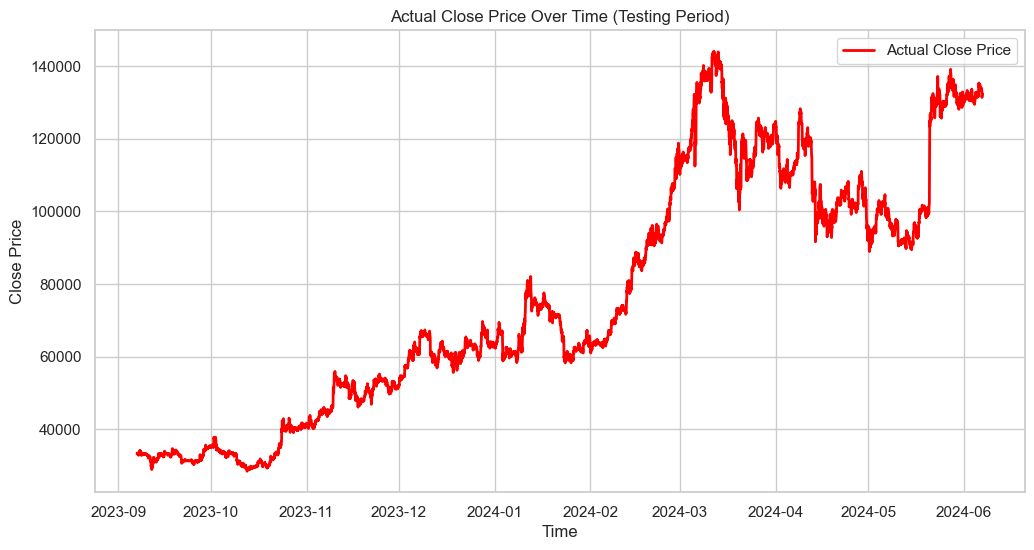

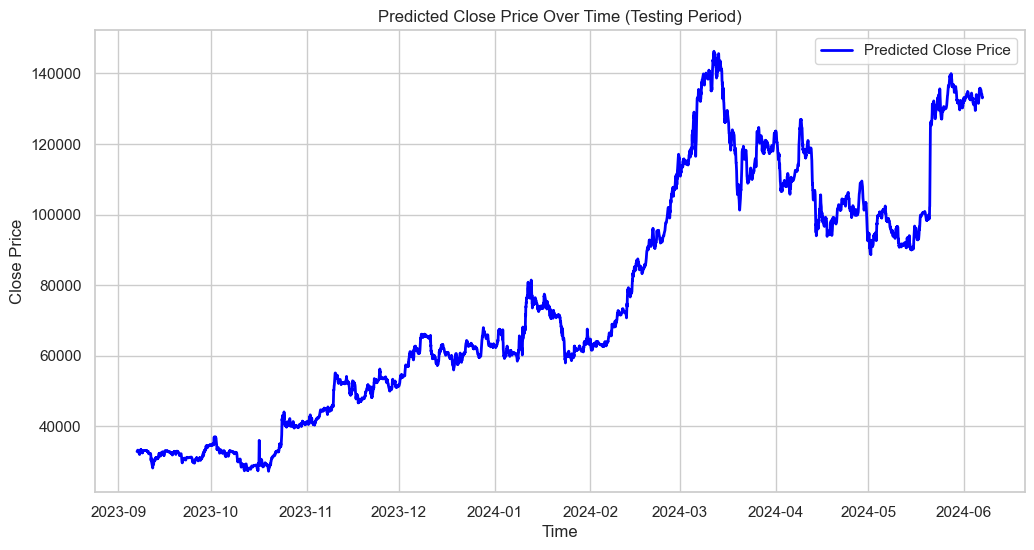

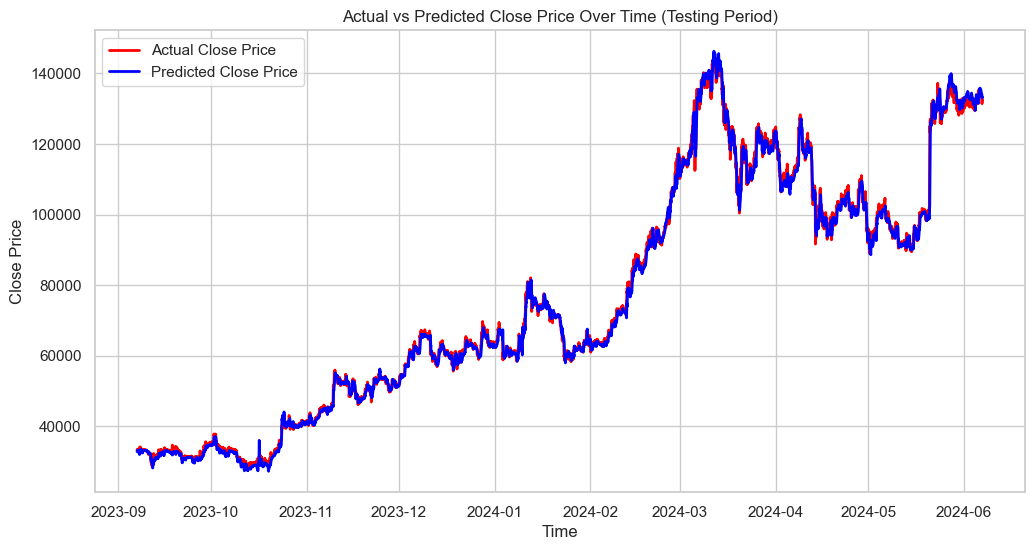

1/1 [==============================] - 0s 8ms/step
Predicted Close Price for the Next Hour: 132924.15122025434


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import seaborn as sns

# Step 1: Load Data from CSV (hourly data)
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/CNN/EthBTC1h.csv'  # Replace with the correct path
data = pd.read_csv(file_path)

# Convert the time column to datetime (using the correct format)
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y %H:%M')
data = data.sort_values('time')

# Step 2: Set the time column as the index and specify the frequency
data.set_index('time', inplace=True)
data = data.asfreq('H')  # Ensure the frequency is hourly

# Check for NaN values before scaling
print("Checking for NaN values in the original data...")
print(data.isna().sum())

# If NaN values exist, we can choose to fill or drop them. Here we fill them with the mean value of the respective column
data = data.fillna(method='ffill').fillna(method='bfill')

# Check again after filling
print("Checking for NaN values after filling...")
print(data.isna().sum())

# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Check for NaN or Infinite values after scaling
print("Checking for NaN or Infinite values in the scaled data...")
print(np.any(np.isnan(data_scaled)))
print(np.any(np.isinf(data_scaled)))

# Step 4: Create sequences for CNN input
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 8])  # Target is 'Eth-close' price (index 8 in the scaled data)
    return np.array(sequences), np.array(targets)

sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Reshape X to fit CNN input requirements: (samples, sequence_length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 5: Train-Test Split (sequential, no shuffling)
train_size = int(X.shape[0] * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Using legacy optimizer for better performance on M1/M2 Macs
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')

# Step 7: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Step 8: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Inverse transform to get the actual prices
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), data_scaled.shape[1]-1)), y_pred), axis=1))[:, -1]

# Step 9: Check and handle NaN values before evaluation
print("Checking for NaN values in y_test_inv and y_pred_inv...")
print(f"NaN in y_test_inv: {np.isnan(y_test_inv).sum()}")
print(f"NaN in y_pred_inv: {np.isnan(y_pred_inv).sum()}")

# Remove NaN values
valid_indices = ~np.isnan(y_test_inv) & ~np.isnan(y_pred_inv)
y_test_inv = y_test_inv[valid_indices]
y_pred_inv = y_pred_inv[valid_indices]

# Ensure arrays are not empty
if len(y_test_inv) == 0 or len(y_pred_inv) == 0:
    print("No valid data to evaluate after removing NaN values.")
else:
    # Evaluate the Model
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')

    # Step 10: Visualization with the testing time frame

    # Correct the index for plotting
    test_index = data.index[sequence_length + train_size:sequence_length + train_size + len(y_test_inv)]

    # Set up the seaborn style for trend lines
    sns.set(style="whitegrid")

    # 1. Actual Data Plot over time (during testing time frame)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_index, y=y_test_inv, label='Actual Close Price', color='red', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 2. Predicted Data Plot over time (during testing time frame)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_index, y=y_pred_inv, label='Predicted Close Price', color='blue', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 3. Combined Actual vs Predicted Plot (during testing time frame)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_index, y=y_test_inv, label='Actual Close Price', color='red', linewidth=2)
    sns.lineplot(x=test_index, y=y_pred_inv, label='Predicted Close Price', color='blue', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # Step 11: Save the Model in .keras Format
    model_filename = 'cnn_model_eth+btc1h.keras'
    model.save(model_filename)
    scaler_filename = 'scaler_eth+btc1h.pkl'
    joblib.dump(scaler, scaler_filename)

    # Step 12: Real-Time Prediction using the last available data
    # Use the last available data to predict the next hour
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    next_hour_prediction_scaled = model.predict(last_sequence)
    next_hour_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, data_scaled.shape[1]-1)), next_hour_prediction_scaled), axis=1))[:, -1]

    print(f'Predicted Close Price for the Next Hour: {next_hour_prediction[0]}')


In [ ]:
btc+eth 1 d

Checking for NaN values in the original data...
Btc-open      0
Btc-high      0
Btc-low       0
Btc-close     0
Btc-volume    0
Eth-open      0
Eth-high      0
Eth-low       0
Eth-volume    0
Eth-close     0
dtype: int64
Checking for NaN values after filling...
Btc-open      0
Btc-high      0
Btc-low       0
Btc-close     0
Btc-volume    0
Eth-open      0
Eth-high      0
Eth-low       0
Eth-volume    0
Eth-close     0
dtype: int64
Checking for NaN or Infinite values in the scaled data...
False
False
Epoch 1/100
26/26 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0138
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0199
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0071
Epoch 5/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0029


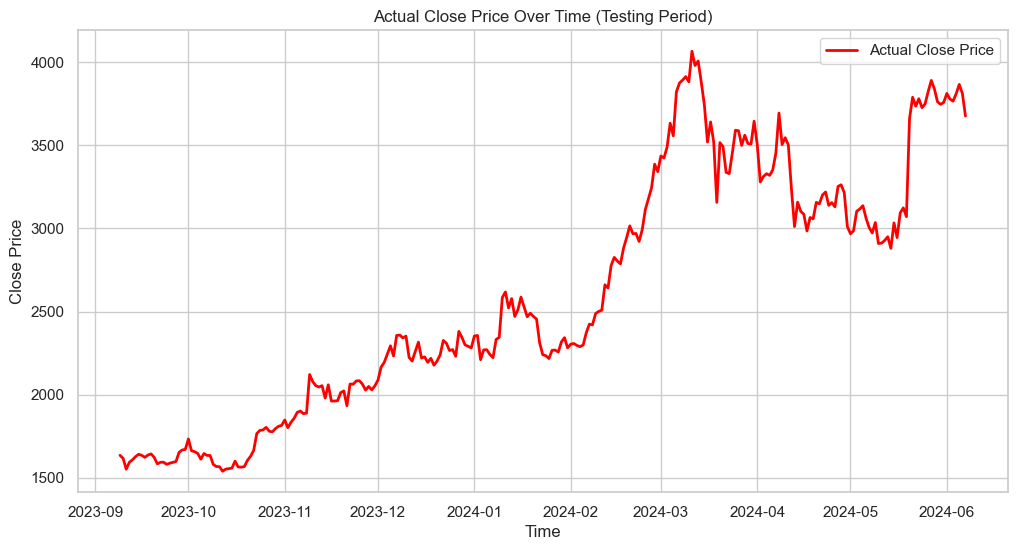

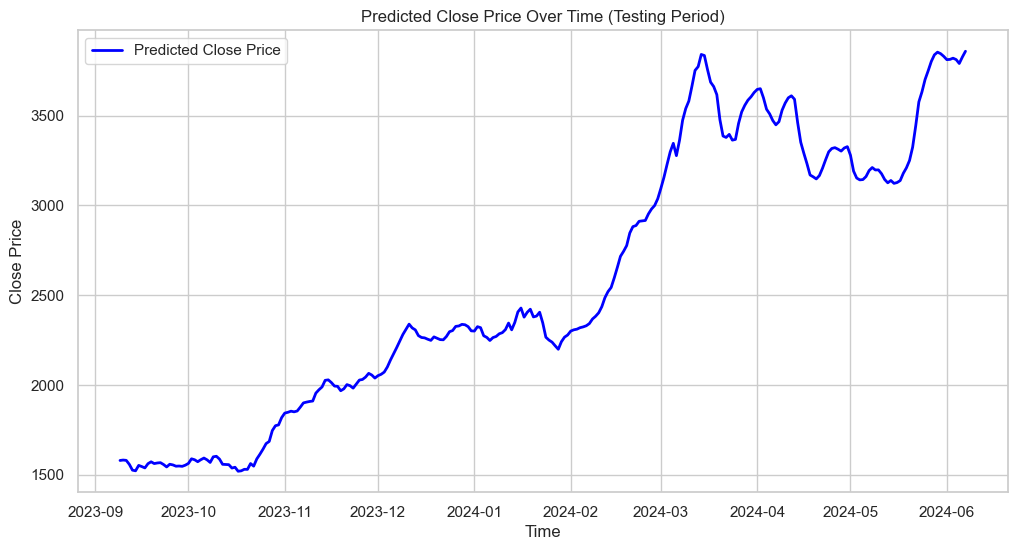

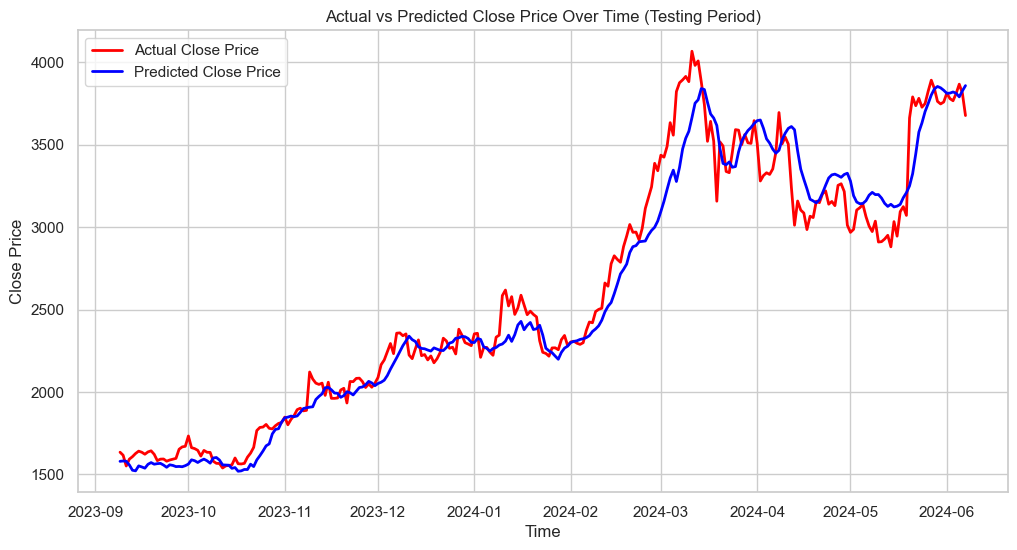

1/1 [==============================] - 0s 9ms/step
Predicted Close Price for the Next Day: 3826.0567138350007


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import seaborn as sns

# Step 1: Load Data from CSV (daily data)
file_path = '/Users/noraizabid/Desktop/Dissertation Algos/CNN/BTCETH_1D_2024_to_2024.csv'  # Replace with the correct path
data = pd.read_csv(file_path)

# Convert the time column to datetime (using the correct format)
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y')
data = data.sort_values('time')

# Step 2: Set the time column as the index and specify the frequency
data.set_index('time', inplace=True)
data = data.asfreq('D')  # Ensure the frequency is daily

# Check for NaN values before scaling
print("Checking for NaN values in the original data...")
print(data.isna().sum())

# If NaN values exist, we can choose to fill or drop them. Here we fill them with the mean value of the respective column
data = data.fillna(method='ffill').fillna(method='bfill')

# Check again after filling
print("Checking for NaN values after filling...")
print(data.isna().sum())

# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Check for NaN or Infinite values after scaling
print("Checking for NaN or Infinite values in the scaled data...")
print(np.any(np.isnan(data_scaled)))
print(np.any(np.isinf(data_scaled)))

# Step 4: Create sequences for CNN input
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 9])  # Target is 'Eth-close' price (index 9 in the scaled data)
    return np.array(sequences), np.array(targets)

sequence_length = 7
X, y = create_sequences(data_scaled, sequence_length)

# Reshape X to fit CNN input requirements: (samples, sequence_length, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 5: Train-Test Split (sequential, no shuffling)
train_size = int(X.shape[0] * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build the CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Using legacy optimizer for better performance on M1/M2 Macs
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')

# Step 7: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Step 8: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Inverse transform to get the actual prices
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), data_scaled.shape[1]-1)), y_pred), axis=1))[:, -1]

# Step 9: Check and handle NaN values before evaluation
print("Checking for NaN values in y_test_inv and y_pred_inv...")
print(f"NaN in y_test_inv: {np.isnan(y_test_inv).sum()}")
print(f"NaN in y_pred_inv: {np.isnan(y_pred_inv).sum()}")

# Remove NaN values
valid_indices = ~np.isnan(y_test_inv) & ~np.isnan(y_pred_inv)
y_test_inv = y_test_inv[valid_indices]
y_pred_inv = y_pred_inv[valid_indices]

# Ensure arrays are not empty
if len(y_test_inv) == 0 or len(y_pred_inv) == 0:
    print("No valid data to evaluate after removing NaN values.")
else:
    # Evaluate the Model
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')

    # Step 10: Visualization with the testing time frame

    # Correct the index for plotting
    test_index = data.index[sequence_length + train_size:sequence_length + train_size + len(y_test_inv)]

    # Set up the seaborn style for trend lines
    sns.set(style="whitegrid")

    # 1. Actual Data Plot over time (during testing time frame)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_index, y=y_test_inv, label='Actual Close Price', color='red', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 2. Predicted Data Plot over time (during testing time frame)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_index, y=y_pred_inv, label='Predicted Close Price', color='blue', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # 3. Combined Actual vs Predicted Plot (during testing time frame)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_index, y=y_test_inv, label='Actual Close Price', color='red', linewidth=2)
    sns.lineplot(x=test_index, y=y_pred_inv, label='Predicted Close Price', color='blue', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Price Over Time (Testing Period)')
    plt.legend()
    plt.show()

    # Step 11: Save the Model in .keras Format
    model_filename = 'cnn_model_btc+eth_1d.keras'
    model.save(model_filename)
    scaler_filename = 'scaler_btc+eth_1d.pkl'
    joblib.dump(scaler, scaler_filename)

    # Step 12: Real-Time Prediction using the last available data
    # Use the last available data to predict the next day
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    next_day_prediction_scaled = model.predict(last_sequence)
    next_day_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, data_scaled.shape[1]-1)), next_day_prediction_scaled), axis=1))[:, -1]

    print(f'Predicted Close Price for the Next Day: {next_day_prediction[0]}')
